In [1]:
import pandas as pd
import numpy as np
from scipy import signal, misc
from datetime import datetime, timedelta

import os
import json

In [2]:
#loading sensor information from Ascendo and Promethean DB
prom_data=pd.read_csv("Device_200011546604332_2019_09_21.csv")
pdf=pd.DataFrame({
    'timestamp':prom_data.TableTimeStamp,
    'milk_temp':prom_data.Parameter2,
    'tank_switch':prom_data.Parameter11,
    'agitator':prom_data.Parameter12,
    'discharge_pump':prom_data.Parameter15,
    'compressor':prom_data.Parameter6,
    'ac_voltage':prom_data.Parameter5,
    'pump_current':prom_data.Parameter7,
    'tss_temp':prom_data.Parameter1
})
ascendo_data=pd.read_csv("Ascendo_200011546604332_2019_09_21.csv")

Promethean Data

In [3]:
pdf[['milk_temp','tank_switch','agitator']].plot()

Ascendo Data

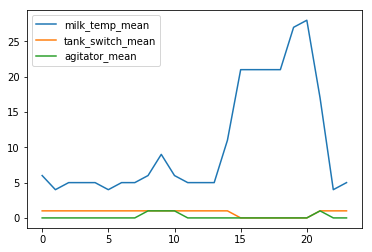

In [4]:
ascendo_data[['milk_temp_mean','tank_switch_mean','agitator_mean']].plot()

# Detecting Milk Present

In [5]:
#life events    
def milk_present(milk_temp_mean):
    if int(milk_temp_mean) in range(12,20): #no product
        return 0
    elif milk_temp_mean in range(25, 35): #fresh product poured in
        return 2
    else:
        return 1
    
def create_life_events(new_df):
    
    new_df['milk_present']=new_df['milk_temp_mean'].apply(milk_present)

    tdf=pd.DataFrame(new_df,columns=['timestamp','milk_present','milk_temp_mean'])
    print(tdf)


life_events= create_life_events(ascendo_data)   

              timestamp  milk_present  milk_temp_mean
0   2019-09-21 00:00:00             1               6
1   2019-09-21 01:00:00             1               4
2   2019-09-21 02:00:00             1               5
3   2019-09-21 03:00:00             1               5
4   2019-09-21 04:00:00             1               5
5   2019-09-21 05:00:00             1               4
6   2019-09-21 06:00:00             1               5
7   2019-09-21 07:00:00             1               5
8   2019-09-21 08:00:00             1               6
9   2019-09-21 09:00:00             1               9
10  2019-09-21 10:00:00             1               6
11  2019-09-21 11:00:00             1               5
12  2019-09-21 12:00:00             1               5
13  2019-09-21 13:00:00             1               5
14  2019-09-21 14:00:00             1              11
15  2019-09-21 15:00:00             1              21
16  2019-09-21 16:00:00             1              21
17  2019-09-21 17:00:00     

# ERROR AT 2:00pm

The temperature went upto 11 but the milk present status is still 1 and only changes to 2 at 7:00pm when fresh milk was poured in (which holds true)

Creating another index for when milk is lifted

milk_present=3 indicates that milk was just lifted

In [6]:
import parameters
def milk_present(milk_temp_mean):
    if int(milk_temp_mean) in range(parameters.milk_not_present_low,parameters.milk_not_present_high): #no product!!!!! Made changes here
        return 0
    elif milk_temp_mean in range(parameters.fresh_product_low, parameters.fresh_product_high): #fresh product poured in
        return 2
    else:
        return 1
    
def create_life_events(new_df):
    
    new_df['milk_present']=new_df['milk_temp_mean'].apply(milk_present)
    new_val=[]
    list_milk=list(new_df['milk_present'])
    i=0
    for row in new_df.milk_present:
        #milk_present=3 indicating Fresh Milk
        if (new_df.milk_present.iloc[i-1]==1)&(row==0):
            new_val.append(3)
        #setting milk_present=1 for when it gets 10-25 range after fresh milk is poured
        elif (new_df.milk_present.iloc[i-1]==2)&(row==0):
            new_val.append(1)
        else:
            new_val.append(row)
        i=i+1
        
    new_df['milk_present']=new_val      
    tdf=pd.DataFrame(new_df,columns=['timestamp','milk_present','milk_temp_mean'])
    print(tdf)

   
life_events= create_life_events(ascendo_data)

              timestamp  milk_present  milk_temp_mean
0   2019-09-21 00:00:00             1               6
1   2019-09-21 01:00:00             1               4
2   2019-09-21 02:00:00             1               5
3   2019-09-21 03:00:00             1               5
4   2019-09-21 04:00:00             1               5
5   2019-09-21 05:00:00             1               4
6   2019-09-21 06:00:00             1               5
7   2019-09-21 07:00:00             1               5
8   2019-09-21 08:00:00             1               6
9   2019-09-21 09:00:00             1               9
10  2019-09-21 10:00:00             1               6
11  2019-09-21 11:00:00             1               5
12  2019-09-21 12:00:00             1               5
13  2019-09-21 13:00:00             1               5
14  2019-09-21 14:00:00             3              11
15  2019-09-21 15:00:00             0              21
16  2019-09-21 16:00:00             0              21
17  2019-09-21 17:00:00     

In [7]:
import parameters

def milk_edgecase(milk_temp_mean):

    if int(milk_temp_mean) in range(parameters.safe_milk_temp_low,parameters.safe_milk_temp_high): #safe temperature
        return 0
    elif milk_temp_mean >parameters.safe_milk_temp_high: #OVER upperbound - hotter product
        return 1
    else: #BELOW lowerbound - cold product
        return 2
    
def milk_present(milk_temp_mean):
    if int(milk_temp_mean) in range(parameters.milk_not_present_low,parameters.milk_not_present_high): #no product!!!!! Made changes here
        return 0
    elif milk_temp_mean in range(parameters.fresh_product_low, parameters.fresh_product_high): #fresh product poured in
        return 2
    else:
        return 1
    
def create_life_events(new_df):
    
    new_df['milk_present']=new_df['milk_temp_mean'].apply(milk_present)
    new_df['milk_temp_edgecase']=new_df['milk_temp_mean'].apply(milk_edgecase)
    new_val=[]
    list_milk=list(new_df['milk_present'])
    i=0
    for row in new_df.milk_present:
        #milk_present=3 indicating milk lift
        if (new_df.milk_present.iloc[i-1]==1)&(row==0):
            new_val.append(3)
        #setting milk_present=1 for when it gets 10-25 range after fresh milk is poured
        elif (new_df.milk_present.iloc[i-1]==2)&(row==0):
            new_val.append(1)
        else:
            new_val.append(row)
        i=i+1
        
    new_df['milk_present']=new_val      
    cooling_process=[]
    #tank switch on and discharge pump on
    for row in new_df.iterrows():

        if (row[1].tank_switch_mean!=0.0) &(row[1].discharge_pump_mean!=0.0):
            cooling_process.append(1) #cooling process in process
        else:
            cooling_process.append(0) 
    new_df['cooling']=cooling_process

    #creatn empty list to fill values into device_life_events table
    datetimelist=[]
    event_id=[]

    
    return new_df
   
life_events= create_life_events(ascendo_data)  
new_df= create_life_events(ascendo_data)

milk present value     description

    0                  no milk present
    1                  milk present
    2                  fresh milk
    3                  milk lift

In [8]:
life_events=life_events.drop(labels=['serial_number','id','device_id','room_temp1_mean','room_temp2_mean','dc_voltage_mean','n_obs'
                         ,'created_by','created_on','updated_by','updated_on',
                        'compressor_mean','pump_current_mean','tss_temp_mean','agitator_mean'],axis=1)
life_events

,milk_temp_mean,tank_switch_mean,discharge_pump_mean,ac_voltage_mean,timestamp,milk_present,milk_temp_edgecase,cooling
0,6,1,0,230,2019-09-21 00:00:00,1,0,0
1,4,1,0,230,2019-09-21 01:00:00,1,0,0
2,5,1,0,233,2019-09-21 02:00:00,1,0,0
3,5,1,0,234,2019-09-21 03:00:00,1,0,0
4,5,1,0,231,2019-09-21 04:00:00,1,0,0
5,4,1,0,230,2019-09-21 05:00:00,1,0,0
6,5,1,0,229,2019-09-21 06:00:00,1,0,0
7,5,1,0,232,2019-09-21 07:00:00,1,0,0
8,6,1,1,229,2019-09-21 08:00:00,1,0,1
9,9,1,1,230,2019-09-21 09:00:00,1,1,1


# Incidents

# Incident 1: AC Voltage if turned OFF Often	

In [9]:
'''
Throughout the day, checking if AC is available when milk is present
milk_present==1 means
milk_temp_edgecase==0 means


'''
incident_1=[]
for t in new_df.iterrows():
    
        # milk_present==1  AND milk_temp_edgecase ==0 AND AC_voltage not in range
        if (t[1].milk_present ==1) & (t[1].milk_temp_edgecase==1) & (int(t[1].ac_voltage_mean) not in range(parameters.ac_voltage_low, parameters.ac_voltage_high)):  #incident 1
                    incident_1.append(1)
        else:
            incident_1.append(0)
new_df['incident_1']=incident_1        
new_df[['timestamp','milk_present','milk_temp_edgecase','ac_voltage_mean','incident_1']]

,timestamp,milk_present,milk_temp_edgecase,ac_voltage_mean,incident_1
0,2019-09-21 00:00:00,1,0,230,0
1,2019-09-21 01:00:00,1,0,230,0
2,2019-09-21 02:00:00,1,0,233,0
3,2019-09-21 03:00:00,1,0,234,0
4,2019-09-21 04:00:00,1,0,231,0
5,2019-09-21 05:00:00,1,0,230,0
6,2019-09-21 06:00:00,1,0,229,0
7,2019-09-21 07:00:00,1,0,232,0
8,2019-09-21 08:00:00,1,0,229,0
9,2019-09-21 09:00:00,1,1,230,0


In [10]:
#checking a hypotheical day
ac_voltage=[222,222,0,0,0,0,222,0,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222]
new_df['ac_voltage']=ac_voltage
incident_1=[]
for t in new_df.iterrows():
        # milk_present==1  AND milk_temp_edgecase ==0 AND AC_voltage not in range
        if (t[1].milk_present ==1) & (t[1].milk_temp_edgecase==0) & (int(t[1].ac_voltage) not in range(parameters.ac_voltage_low, parameters.ac_voltage_high)):  #incident 1
                incident_1.append(1)    
                #print('Incident 1: No AC when milk is present @',t[1][15])                 
        else:
            incident_1.append(0)

new_df['incident_1']=incident_1        
new_df[['timestamp','milk_present','milk_temp_edgecase','ac_voltage','incident_1']]

,timestamp,milk_present,milk_temp_edgecase,ac_voltage,incident_1
0,2019-09-21 00:00:00,1,0,222,0
1,2019-09-21 01:00:00,1,0,222,0
2,2019-09-21 02:00:00,1,0,0,1
3,2019-09-21 03:00:00,1,0,0,1
4,2019-09-21 04:00:00,1,0,0,1
5,2019-09-21 05:00:00,1,0,0,1
6,2019-09-21 06:00:00,1,0,222,0
7,2019-09-21 07:00:00,1,0,0,1
8,2019-09-21 08:00:00,1,0,222,0
9,2019-09-21 09:00:00,1,1,222,0


# Incident 2: Discharge pump going OFF

In [11]:
'''
milk is present and over 6, but Discharge pump is OFF
'''
incident_2=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1) & (t[1].milk_temp_mean>parameters.safe_milk_temp_high) & (t[1].discharge_pump_mean==0):  #incident 2
                    incident_2.append(1)
    else:
        incident_2.append(0)
new_df['incident_2']=incident_2    
new_df[['timestamp','milk_present','milk_temp_mean','discharge_pump_mean','incident_2']]    


,timestamp,milk_present,milk_temp_mean,discharge_pump_mean,incident_2
0,2019-09-21 00:00:00,1,6,0,0
1,2019-09-21 01:00:00,1,4,0,0
2,2019-09-21 02:00:00,1,5,0,0
3,2019-09-21 03:00:00,1,5,0,0
4,2019-09-21 04:00:00,1,5,0,0
5,2019-09-21 05:00:00,1,4,0,0
6,2019-09-21 06:00:00,1,5,0,0
7,2019-09-21 07:00:00,1,5,0,0
8,2019-09-21 08:00:00,1,6,1,0
9,2019-09-21 09:00:00,1,9,1,0


In [12]:
#hypotetical day
discharge_pump=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

new_df['discharge_pump']=discharge_pump
incident_2=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1) & (t[1].milk_temp_mean>parameters.safe_milk_temp_high) & (t[1].discharge_pump==0):  #incident 2
                    incident_2.append(1)
    else:
        incident_2.append(0)
new_df['incident_2']=incident_2    
new_df[['timestamp','milk_present','milk_temp_mean','discharge_pump','incident_2']] 

,timestamp,milk_present,milk_temp_mean,discharge_pump,incident_2
0,2019-09-21 00:00:00,1,6,0,0
1,2019-09-21 01:00:00,1,4,0,0
2,2019-09-21 02:00:00,1,5,0,0
3,2019-09-21 03:00:00,1,5,0,0
4,2019-09-21 04:00:00,1,5,0,0
5,2019-09-21 05:00:00,1,4,0,0
6,2019-09-21 06:00:00,1,5,0,0
7,2019-09-21 07:00:00,1,5,0,0
8,2019-09-21 08:00:00,1,6,0,0
9,2019-09-21 09:00:00,1,9,0,1


# Incident 3: Tank Switch being turned OFF	

In [13]:
'''
Milk present but Tank Switch OFF 
'''
incident_3=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch_mean==0):  #incident 3
        incident_3.append(1)
    else:
        incident_3.append(0)
new_df['incident_3']=incident_3    
new_df[['timestamp','milk_present','milk_temp_mean','tank_switch_mean','incident_3']]    


,timestamp,milk_present,milk_temp_mean,tank_switch_mean,incident_3
0,2019-09-21 00:00:00,1,6,1,0
1,2019-09-21 01:00:00,1,4,1,0
2,2019-09-21 02:00:00,1,5,1,0
3,2019-09-21 03:00:00,1,5,1,0
4,2019-09-21 04:00:00,1,5,1,0
5,2019-09-21 05:00:00,1,4,1,0
6,2019-09-21 06:00:00,1,5,1,0
7,2019-09-21 07:00:00,1,5,1,0
8,2019-09-21 08:00:00,1,6,1,0
9,2019-09-21 09:00:00,1,9,1,0


In [14]:
#hypothetical day
tank_switch=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

new_df['tank_switch']=tank_switch
incident_3=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch==0):  #incident 3
        incident_3.append(1)
    else:
        incident_3.append(0)
new_df['incident_3']=incident_3    
new_df[['timestamp','milk_present','tank_switch','incident_3']]    

,timestamp,milk_present,tank_switch,incident_3
0,2019-09-21 00:00:00,1,0,1
1,2019-09-21 01:00:00,1,0,1
2,2019-09-21 02:00:00,1,0,1
3,2019-09-21 03:00:00,1,0,1
4,2019-09-21 04:00:00,1,0,1
5,2019-09-21 05:00:00,1,0,1
6,2019-09-21 06:00:00,1,0,1
7,2019-09-21 07:00:00,1,0,1
8,2019-09-21 08:00:00,1,0,1
9,2019-09-21 09:00:00,1,0,1


# Incident 4: Pattern of not enough cooling	

In [15]:
'''
Milk present but cooling hasnt began
Cooling is defined as time when Tank Switch and Discharge Pump is ON
'''
incident_4=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch_mean==0) & (t[1].discharge_pump_mean==0):  #incident 4
        incident_4.append(1)
    else:
        incident_4.append(0)
new_df['incident_4']=incident_4    
new_df[['timestamp','milk_present','milk_temp_mean','tank_switch_mean','discharge_pump_mean','incident_4']]    

,timestamp,milk_present,milk_temp_mean,tank_switch_mean,discharge_pump_mean,incident_4
0,2019-09-21 00:00:00,1,6,1,0,0
1,2019-09-21 01:00:00,1,4,1,0,0
2,2019-09-21 02:00:00,1,5,1,0,0
3,2019-09-21 03:00:00,1,5,1,0,0
4,2019-09-21 04:00:00,1,5,1,0,0
5,2019-09-21 05:00:00,1,4,1,0,0
6,2019-09-21 06:00:00,1,5,1,0,0
7,2019-09-21 07:00:00,1,5,1,0,0
8,2019-09-21 08:00:00,1,6,1,1,0
9,2019-09-21 09:00:00,1,9,1,1,0


In [16]:
#hypothetical day

discharge_pump=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
new_df['discharge_pump']=discharge_pump
tank_switch=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
new_df['tank_switch']=tank_switch
incident_4=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch==0) & (t[1].discharge_pump==0):  #incident 4
        incident_4.append(1)
    else:
        incident_4.append(0)
new_df['incident_4']=incident_4    
new_df[['timestamp','milk_present','tank_switch','discharge_pump','incident_4']]

,timestamp,milk_present,tank_switch,discharge_pump,incident_4
0,2019-09-21 00:00:00,1,0,0,1
1,2019-09-21 01:00:00,1,0,0,1
2,2019-09-21 02:00:00,1,0,0,1
3,2019-09-21 03:00:00,1,0,0,1
4,2019-09-21 04:00:00,1,0,0,1
5,2019-09-21 05:00:00,1,0,0,1
6,2019-09-21 06:00:00,1,0,0,1
7,2019-09-21 07:00:00,1,0,0,1
8,2019-09-21 08:00:00,1,0,0,1
9,2019-09-21 09:00:00,1,0,0,1


# Incident 5: Pattern of Tank switch being ON when not required	

In [17]:
'''
No Milk but Tank Switch is ON
'''
incident_5=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==0)  & (t[1].tank_switch_mean==1) :  #incident 5
        incident_5.append(1)
    else:
        incident_5.append(0)
new_df['incident_5']=incident_5    
new_df[['timestamp','milk_present','milk_temp_mean','tank_switch_mean','incident_5']]    

,timestamp,milk_present,milk_temp_mean,tank_switch_mean,incident_5
0,2019-09-21 00:00:00,1,6,1,0
1,2019-09-21 01:00:00,1,4,1,0
2,2019-09-21 02:00:00,1,5,1,0
3,2019-09-21 03:00:00,1,5,1,0
4,2019-09-21 04:00:00,1,5,1,0
5,2019-09-21 05:00:00,1,4,1,0
6,2019-09-21 06:00:00,1,5,1,0
7,2019-09-21 07:00:00,1,5,1,0
8,2019-09-21 08:00:00,1,6,1,0
9,2019-09-21 09:00:00,1,9,1,0


In [18]:
#hypothetical day

tank_switch=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
new_df['tank_switch']=tank_switch
incident_5=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch==0):  #incident 5
        incident_5.append(1)
    else:
        incident_5.append(0)
new_df['incident_5']=incident_5    
new_df[['timestamp','milk_present','tank_switch','incident_5']]

,timestamp,milk_present,tank_switch,incident_5
0,2019-09-21 00:00:00,1,0,1
1,2019-09-21 01:00:00,1,0,1
2,2019-09-21 02:00:00,1,0,1
3,2019-09-21 03:00:00,1,0,1
4,2019-09-21 04:00:00,1,0,1
5,2019-09-21 05:00:00,1,0,1
6,2019-09-21 06:00:00,1,0,1
7,2019-09-21 07:00:00,1,0,1
8,2019-09-21 08:00:00,1,0,1
9,2019-09-21 09:00:00,1,0,1


# Incident 6:  No Milk but Tank Switch is ON for more than 3 hours

In [19]:
'''
No Milk but Tank Switch is ON for more than 3 hours
'''
#hypothetical day 
count_6=0
i=1
tank_switch=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
new_df['tank_switch']=tank_switch
incident_6=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==0)  & (t[1].tank_switch==1) :  #incident 6
        incident_6.append(1)
    else:
        incident_6.append(0)
    i=i+1
   
new_val=[]
i=1
milk_present=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0]
new_df['milk_present']=milk_present
for t in new_df.iterrows():
    if (t[1].milk_present ==0)  & (t[1].tank_switch==1) :  #incident 6    
        count_6=count_6+1
        if (count_6>3)&(incident_6[i-1]==1):
            new_val.append(1)
        else:
            new_val.append(0)
    else:
            new_val.append(0) 
            count_6=0
    i=i+1  
new_df['incident_6']=new_val 
new_df[['timestamp','milk_present','tank_switch','incident_6']]    

,timestamp,milk_present,tank_switch,incident_6
0,2019-09-21 00:00:00,1,1,0
1,2019-09-21 01:00:00,1,1,0
2,2019-09-21 02:00:00,1,1,0
3,2019-09-21 03:00:00,1,1,0
4,2019-09-21 04:00:00,1,1,0
5,2019-09-21 05:00:00,1,1,0
6,2019-09-21 06:00:00,1,1,0
7,2019-09-21 07:00:00,1,1,0
8,2019-09-21 08:00:00,1,1,0
9,2019-09-21 09:00:00,1,1,0


# Incident 10: Tank switch ON during milk lift

In [20]:
def milk_present(milk_temp_mean):
    if int(milk_temp_mean) in range(parameters.milk_not_present_low,parameters.milk_not_present_high): #no product!!!!! Made changes here
        return 0
    elif milk_temp_mean in range(parameters.fresh_product_low, parameters.fresh_product_high): #fresh product poured in
        return 2
    else:
        return 1
    
def create_life_events(new_df):
    
    new_df['milk_present']=new_df['milk_temp_mean'].apply(milk_present)
    new_val=[]
    list_milk=list(new_df['milk_present'])
    i=0
    for row in new_df.milk_present:
        #milk_present=3 indicating Fresh Milk
        if (new_df.milk_present.iloc[i-1]==1)&(row==0):
            new_val.append(3)
        #setting milk_present=1 for when it gets 10-25 range after fresh milk is poured
        elif (new_df.milk_present.iloc[i-1]==2)&(row==0):
            new_val.append(1)
        else:
            new_val.append(row)
        i=i+1
        
    new_df['milk_present']=new_val      
    
    return new_df


new_df= create_life_events(ascendo_data)
incident_10=[]
for row in new_df.iterrows():
    if (row[1].milk_present==3)&(row[1].tank_switch_mean==1):
        incident_10.append(1)
    else: 
        incident_10.append(0)
        
new_df['incident_10']=incident_10
new_df[['milk_temp_mean','milk_present','tank_switch_mean','incident_10','timestamp']]

,milk_temp_mean,milk_present,tank_switch_mean,incident_10,timestamp
0,6,1,1,0,2019-09-21 00:00:00
1,4,1,1,0,2019-09-21 01:00:00
2,5,1,1,0,2019-09-21 02:00:00
3,5,1,1,0,2019-09-21 03:00:00
4,5,1,1,0,2019-09-21 04:00:00
5,4,1,1,0,2019-09-21 05:00:00
6,5,1,1,0,2019-09-21 06:00:00
7,5,1,1,0,2019-09-21 07:00:00
8,6,1,1,0,2019-09-21 08:00:00
9,9,1,1,0,2019-09-21 09:00:00


In [21]:
incident_details=pd.read_csv("incident_details.csv")
incident_details.drop(labels=['promethean_device_id','end_customer_id','created_by','created_on','updated_by','updated_on'], axis=1, inplace=True)
incident_details

,id,incident_name,incident_type,description,priority,threshold_time,threshold_count,threshold_time_units
0,1,AC Voltage if turned OFF Often,"Milk Temperature over 6,but no AC",Site,High,9,7,Days
1,2,Pattern of Discharge pump going OFF,"Milk Temperature over 6,but discharge pump OFF",System,High,1,1,Days
2,3,Pattern of Tank Switch being turned OFF,Milk present but Tank Switch OFF,System,Critical,3,7,Days
3,4,Pattern of not enough cooling,Milk present but cooling hasnt began,System,Critical,1,1,Days
4,5,Pattern of Tank switch being ON when not required,No Milk but Tank Switch is ON,System,High,2,7,Days
5,6,Tank Switch ON more than 3 hours,No Milk but Tank Switch is ON for more than 3 ...,System,Critical,1,1,Days
6,7,Cyclic mode is going OFF when it should not be,Milk temperature in safe range but Agitator Cy...,System,Critical,1,1,Days
7,8,Agitator ON for too long,Avgerage time for Agitator to get into ACM is ...,System,Pattern,1,1,Days
8,9,Charging TSS is taking longer than normal,Avgerage time for TSS to charge is long,System,Pattern,1,1,Days
9,10,Tank switch ON during milk lift,Tank switch and agitator ON during milk lift,System,Critical,3,7,Days


In [22]:
def give_hour(t):
            day,un,hour=str(t).split(" ")
            return hour
    
def split_month(t):
    year,month,rest=str(t).split("-")
    return month

def split_day(t):
            day,hour=str(t).split(" ")
            return day
def split_year(t):
    year,month,rest=str(t).split("-")
    return year

def combine_mins(t):
            day,hour=str(t).split(" ")
            hour,mins,seconds=str(hour).split(":")
            return hour
        
def split_date(data):
    data['date']=data.timestamp.apply(split_day)
    data['year']=data.timestamp.apply(split_year)
    data['month']=data.timestamp.apply(split_month)
    data['hour']=data.timestamp.apply(combine_mins)
    return data

# Incident 7:  Cyclic mode is going OFF when it should not be

# Incident 8: Agitator ON for too long

# Incident 9: Charging TSS is taking longer than normal

In [42]:
print(parameters.tss_low, parameters.tss_max)
def tss_edgecase(TssTemperature):
    if(TssTemperature>parameters.tss_low):
        return 1  #tss temperature too high! over 0 degrees
    elif TssTemperature<= parameters.tss_max:
        return 2 #tss temp lower than -4
    else:
        return 0 #tss between 0 and -4
    
    
def tss_function(data):
    charging=0
    flag=0
    for row in data.iterrows():
        #ac present and milk is present 
        if row[1].ac_voltage!=0 & int(row[1].milk_temp) in range(parameters.safe_milk_temp_low, parameters.milk_not_present_low):
            if row[1].tss_temp==1: #if tss_temp is higher than 0, then charging has to start
                charging=1+charging
                if charging==1:
                        flag=1     
                        starttime=row[1].timestamp
                        starttemp=row[1].milk_temp
                        print('Starting to charge at ',starttime,' with tss temp: ',starttemp,' and AC at ',row[1][2])
                    
            elif row[1].tss_temp==2: #has reached safe tss_temp
                if flag==1: #if charging is going on, then now it's in safe temp
                        flag=0
                        charging=0
                        if (row[1].timestamp-starttime)<= timedelta(days=1):#check for milk present
                            print('Charged at ',row[1][0],' with tss temp: ',row[1][1],' and AC at ',row[1][2])
                            print('\t'*10,'Time Taken: ', row[1][0]-starttime)
                            df.loc[j]=(j,device,starttime,starttemp,row[1][0],row[1][1],(row[1][0]-starttime),'Tss charging')
                            j=j+1
        else:
            charging=0
            flag=0
       
    return data
            
data = pdf
data['tss']=data['tss_temp'].apply(tss_edgecase)
data=tss_function(data)
data.head()
data.to_csv('tss.csv')

0 -4


In [31]:
pdf.columns

Index(['ac_voltage', 'agitator', 'compressor', 'discharge_pump', 'milk_temp',
       'pump_current', 'tank_switch', 'timestamp', 'tss_temp', 'acm'],
      dtype='object')

In [45]:
'''
Avgerage time for Agitator to get into ACM is ...
'''

def detect_acm(data):
    #checking for acm mode
    acm=[]
    agitator_on=0 
    acm_on=0 #counts the number of minutes when the agitator was on in an acm cycle
    flag=0
    for row in data.iterrows():
        #print(row[1].milk_temp)
        if (row[1].milk_temp<=parameters.safe_milk_temp_high)&(row[1].milk_temp>parameters.safe_milk_temp_low): #if milk is present and below upper limit
            if row[1].agitator==1:
                agitator_on=agitator_on+1
                if agitator_on==1: #begining of the cycle--could be in acm or just on for long
                    flag=1  
                    starttime=row[1].timestamp
                    startmilktemp=row[1].milk_temp
                    print('Starting cycle at ',starttime,' with milk temp: ',startmilktemp)
                    acm.append(1)

                elif acm_on!=0: #end of acm cylce
                    acm.append(1)
                    print('Ending cycle at ',row[1].timestamp,' with milk temp: ',row[1].milk_temp,' with ',acm_on,' cycles')
                    flag=1
                    acm_on=0
                    
                else:
                    acm.append(0)
            elif row[1].agitator==0:
                if flag==1: 
                    acm_on=acm_on+1 
                    acm.append(1)
                    print('Agitator in cyclic mode for ',acm_on,' cycles')
                else:
                    acm.append(0)
            else:
                acm.append(0)
        else:
                acm.append(0)
                flag=0
                agitator_on=0

    print('Detected ACM cycles')            
    data['acm']=acm
    return data

df=pd.DataFrame(columns=['id','serial_number', 'start_time','start_temp','end_time','end_temp','total_time','event_name'])


data = pdf
data = detect_acm(data)
data = split_date(data)
starttime=datetime.now()
starttemp=0
count=0
data[['ac_voltage','agitator','milk_temp','acm','timestamp']].tail(200)


Starting cycle at  2019-09-21 00:02:02  with milk temp:  5.3
Agitator in cyclic mode for  1  cycles
Agitator in cyclic mode for  2  cycles
Agitator in cyclic mode for  3  cycles
Agitator in cyclic mode for  4  cycles
Agitator in cyclic mode for  5  cycles
Agitator in cyclic mode for  6  cycles
Ending cycle at  2019-09-21 00:16:02  with milk temp:  5.8  with  6  cycles
Agitator in cyclic mode for  1  cycles
Agitator in cyclic mode for  2  cycles
Agitator in cyclic mode for  3  cycles
Agitator in cyclic mode for  4  cycles
Agitator in cyclic mode for  5  cycles
Ending cycle at  2019-09-21 00:30:02  with milk temp:  5.5  with  5  cycles
Agitator in cyclic mode for  1  cycles
Ending cycle at  2019-09-21 00:34:02  with milk temp:  5.7  with  1  cycles
Agitator in cyclic mode for  1  cycles
Agitator in cyclic mode for  2  cycles
Ending cycle at  2019-09-21 00:40:02  with milk temp:  5.9  with  2  cycles
Agitator in cyclic mode for  1  cycles
Agitator in cyclic mode for  2  cycles
Ending cycl

Agitator in cyclic mode for  6  cycles
Agitator in cyclic mode for  7  cycles
Ending cycle at  2019-09-21 13:28:00  with milk temp:  4.5  with  7  cycles
Agitator in cyclic mode for  1  cycles
Agitator in cyclic mode for  2  cycles
Agitator in cyclic mode for  3  cycles
Agitator in cyclic mode for  4  cycles
Agitator in cyclic mode for  5  cycles
Agitator in cyclic mode for  6  cycles
Ending cycle at  2019-09-21 13:42:00  with milk temp:  5.1  with  6  cycles
Agitator in cyclic mode for  1  cycles
Agitator in cyclic mode for  2  cycles
Agitator in cyclic mode for  3  cycles
Agitator in cyclic mode for  4  cycles
Agitator in cyclic mode for  5  cycles
Agitator in cyclic mode for  6  cycles
Agitator in cyclic mode for  7  cycles
Ending cycle at  2019-09-21 13:58:00  with milk temp:  4.7  with  7  cycles
Agitator in cyclic mode for  1  cycles
Agitator in cyclic mode for  2  cycles
Agitator in cyclic mode for  3  cycles
Agitator in cyclic mode for  4  cycles
Agitator in cyclic mode for  5 

,ac_voltage,agitator,milk_temp,acm,timestamp
520,228,0,21.2,0,2019-09-21 17:20:01
521,228,0,21.2,0,2019-09-21 17:22:01
522,231,0,21.2,0,2019-09-21 17:24:01
523,231,0,21.2,0,2019-09-21 17:26:01
524,230,0,21.2,0,2019-09-21 17:28:01
525,230,0,21.2,0,2019-09-21 17:30:01
526,231,0,21.2,0,2019-09-21 17:32:01
527,232,0,21.2,0,2019-09-21 17:34:01
528,231,0,21.2,0,2019-09-21 17:36:01
529,229,0,21.2,0,2019-09-21 17:38:01


In [46]:
data.to_csv('acm.csv')


In [61]:
'''
Avgerage time for Agitator to get into ACM is ...
'''

def detect_acm(data):
    #checking for acm mode
    acm=[]
    agitator_on=0 
    acm_on=0 #counts the number of minutes when the agitator was on in an acm cycle
    flag=0
    
    for row in data.iterrows():
            if row[1].agitator==1:
                acm.append(1)
                agitator_on=agitator_on+1
                
                if agitator_on==1: #begining of the cycle--could be in acm or just on for long
                    flag=1  
                    
                if acm_on!=0:
                    flag=0
                    agitator_on=0
            else: 
                
                if flag==1: 
                    acm_on=1
                    acm.append(1)
                    #print('Agitator in cyclic mode for ',acm_on,' cycles')
                else:
                    acm.append(0)
                    agitator_on=0
                    acm_on=0
                    flag=0


    print('Detected ACM cycles')            
    data['acm']=acm
    return data

df=pd.DataFrame(columns=['id','serial_number', 'start_time','start_temp','end_time','end_temp','total_time','event_name'])


data = pdf
data = detect_acm(data)
data = split_date(data)
starttime=datetime.now()
starttemp=0
count=0
data[['ac_voltage','agitator','milk_temp','acm','timestamp']].tail(200)


Detected ACM cycles


,ac_voltage,agitator,milk_temp,acm,timestamp
520,228,0,21.2,1,2019-09-21 17:20:01
521,228,0,21.2,1,2019-09-21 17:22:01
522,231,0,21.2,1,2019-09-21 17:24:01
523,231,0,21.2,1,2019-09-21 17:26:01
524,230,0,21.2,1,2019-09-21 17:28:01
525,230,0,21.2,1,2019-09-21 17:30:01
526,231,0,21.2,1,2019-09-21 17:32:01
527,232,0,21.2,1,2019-09-21 17:34:01
528,231,0,21.2,1,2019-09-21 17:36:01
529,229,0,21.2,1,2019-09-21 17:38:01


In [35]:
for row in data.iterrows():
        if row[1][1]<=6: #if milk temperature is below upper limit
            count=count+1
            if count==1:
                starttime=row[1][0]
                starttemp=row[1][1]
                print(row[1][0],': Agitator ON with milk temp ',row[1][1])

        if row[1][3]==1 & count!=0:

            if count!=1:
                if ((row[1][0]-starttime) > timedelta(minutes=20)) & ((row[1][0]-starttime) < timedelta(days=1)):
                    df.loc[j]=(j,device,starttime,starttemp,row[1][0],row[1][1],(row[1][0]-starttime),'acm')
                    j=j+1
                    print(row[1][0],': Agitator got into cyclic Mode, with count=',count,' and milk temp=',row[1][1])
                    print('\t'*12,'Time Taken to get into ACM ',(row[1][0]-starttime))
                    
            count=0

230 : Agitator ON with milk temp  0


TypeError: unorderable types: int() > datetime.timedelta()

# Incident 8: 